In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient direction
direction = new_data[['WIND_DIRECTION']]
print(direction)

# count the NaN values
nan_count_direction = direction['WIND_DIRECTION'].isna().sum()
print(nan_count_direction)
# there are 7156 NaN values
# fill them with backfill
direction = direction.fillna(method='bfill')
print(direction.isna().sum())

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=direction.index.min(), end=direction.index.max(), freq='5T')
missing_timestamps = complete_range.difference(direction.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
direction_incomplete = df_complete_range.merge(direction, left_index=True, right_index=True, how='left')
# print(direction_incomplete)
direction_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
direction_all = direction_incomplete.bfill()
print(direction_all)
direction_all.isna().sum() # okay

str(direction_all.index.dtype) # okay

parameter_type             WIND_DIRECTION
acquisition_timestamp                    
2020-10-13 10:20:00+00:00             NaN
2020-10-13 10:25:00+00:00           294.0
2020-10-13 10:30:00+00:00           282.0
2020-10-13 10:35:00+00:00           301.0
2020-10-13 10:40:00+00:00           289.0
...                                   ...
2023-05-31 21:35:00+00:00           156.0
2023-05-31 21:40:00+00:00           157.0
2023-05-31 21:45:00+00:00           162.0
2023-05-31 21:50:00+00:00            53.0
2023-05-31 21:55:00+00:00           212.0

[271508 rows x 1 columns]
7156
parameter_type
WIND_DIRECTION    0
dtype: int64
5112
                           WIND_DIRECTION
2020-10-13 10:20:00+00:00           294.0
2020-10-13 10:25:00+00:00           294.0
2020-10-13 10:30:00+00:00           282.0
2020-10-13 10:35:00+00:00           301.0
2020-10-13 10:40:00+00:00           289.0
...                                   ...
2023-05-31 21:35:00+00:00           156.0
2023-05-31 21:40:00+00:00        

C:\Users\reginab\AppData\Local\Temp\ipykernel_20264\3768661545.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  direction = direction.fillna(method='bfill')


'datetime64[ns, UTC]'

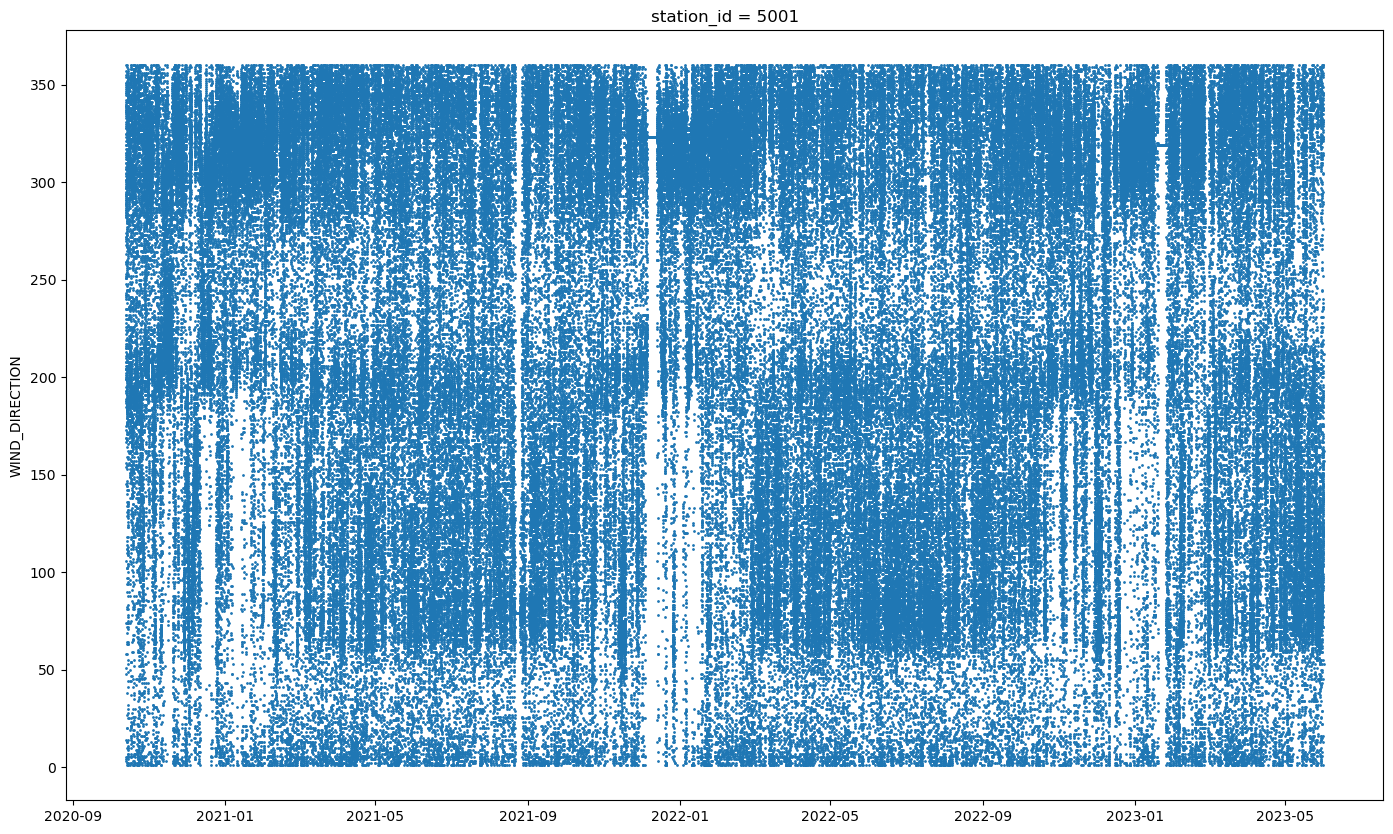

In [3]:
# plot 'WIND_DIRECTION'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(direction_all.index, direction_all['WIND_DIRECTION'],s=1)
ax.set_ylabel('WIND_DIRECTION')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           WIND_DIRECTION
2020-10-13 10:00:00+00:00      293.625000
2020-10-13 11:00:00+00:00      312.666667
2020-10-13 12:00:00+00:00      270.833333
2020-10-13 13:00:00+00:00      291.083333
2020-10-13 14:00:00+00:00      280.416667
...                                   ...
2023-05-31 17:00:00+00:00      197.000000
2023-05-31 18:00:00+00:00      220.166667
2023-05-31 19:00:00+00:00      185.250000
2023-05-31 20:00:00+00:00      161.833333
2023-05-31 21:00:00+00:00      176.250000

[23052 rows x 1 columns]


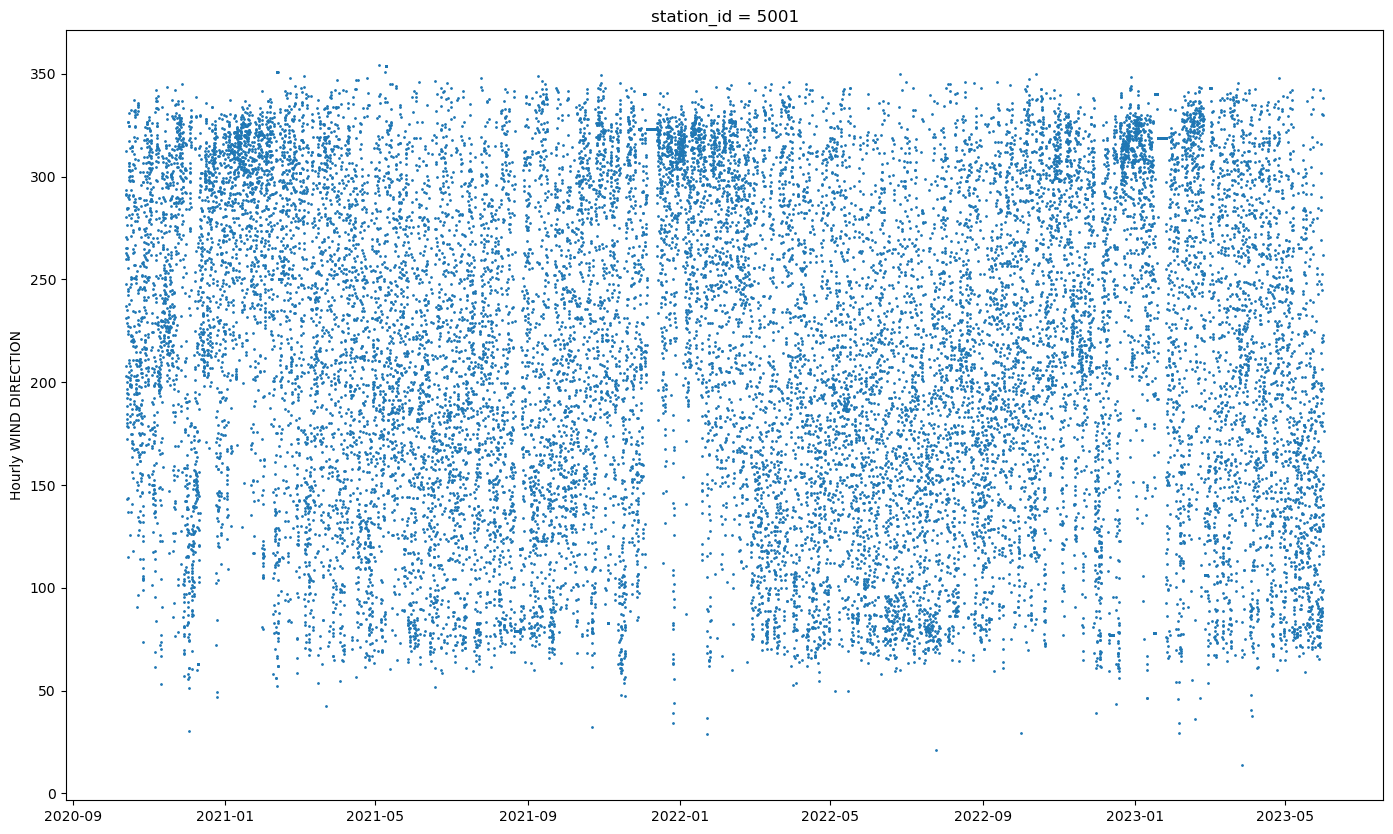

In [4]:
# hourly data
# sum the values for each hour and take the mean

str(direction_all.index.dtype) # okay
direction_hourly = direction_all.resample('H').mean()
print(direction_hourly)

# plot hourly 'WIND_DIRECTION'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(direction_hourly.index, direction_hourly['WIND_DIRECTION'],s=1)
ax.set_ylabel('Hourly WIND DIRECTION')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

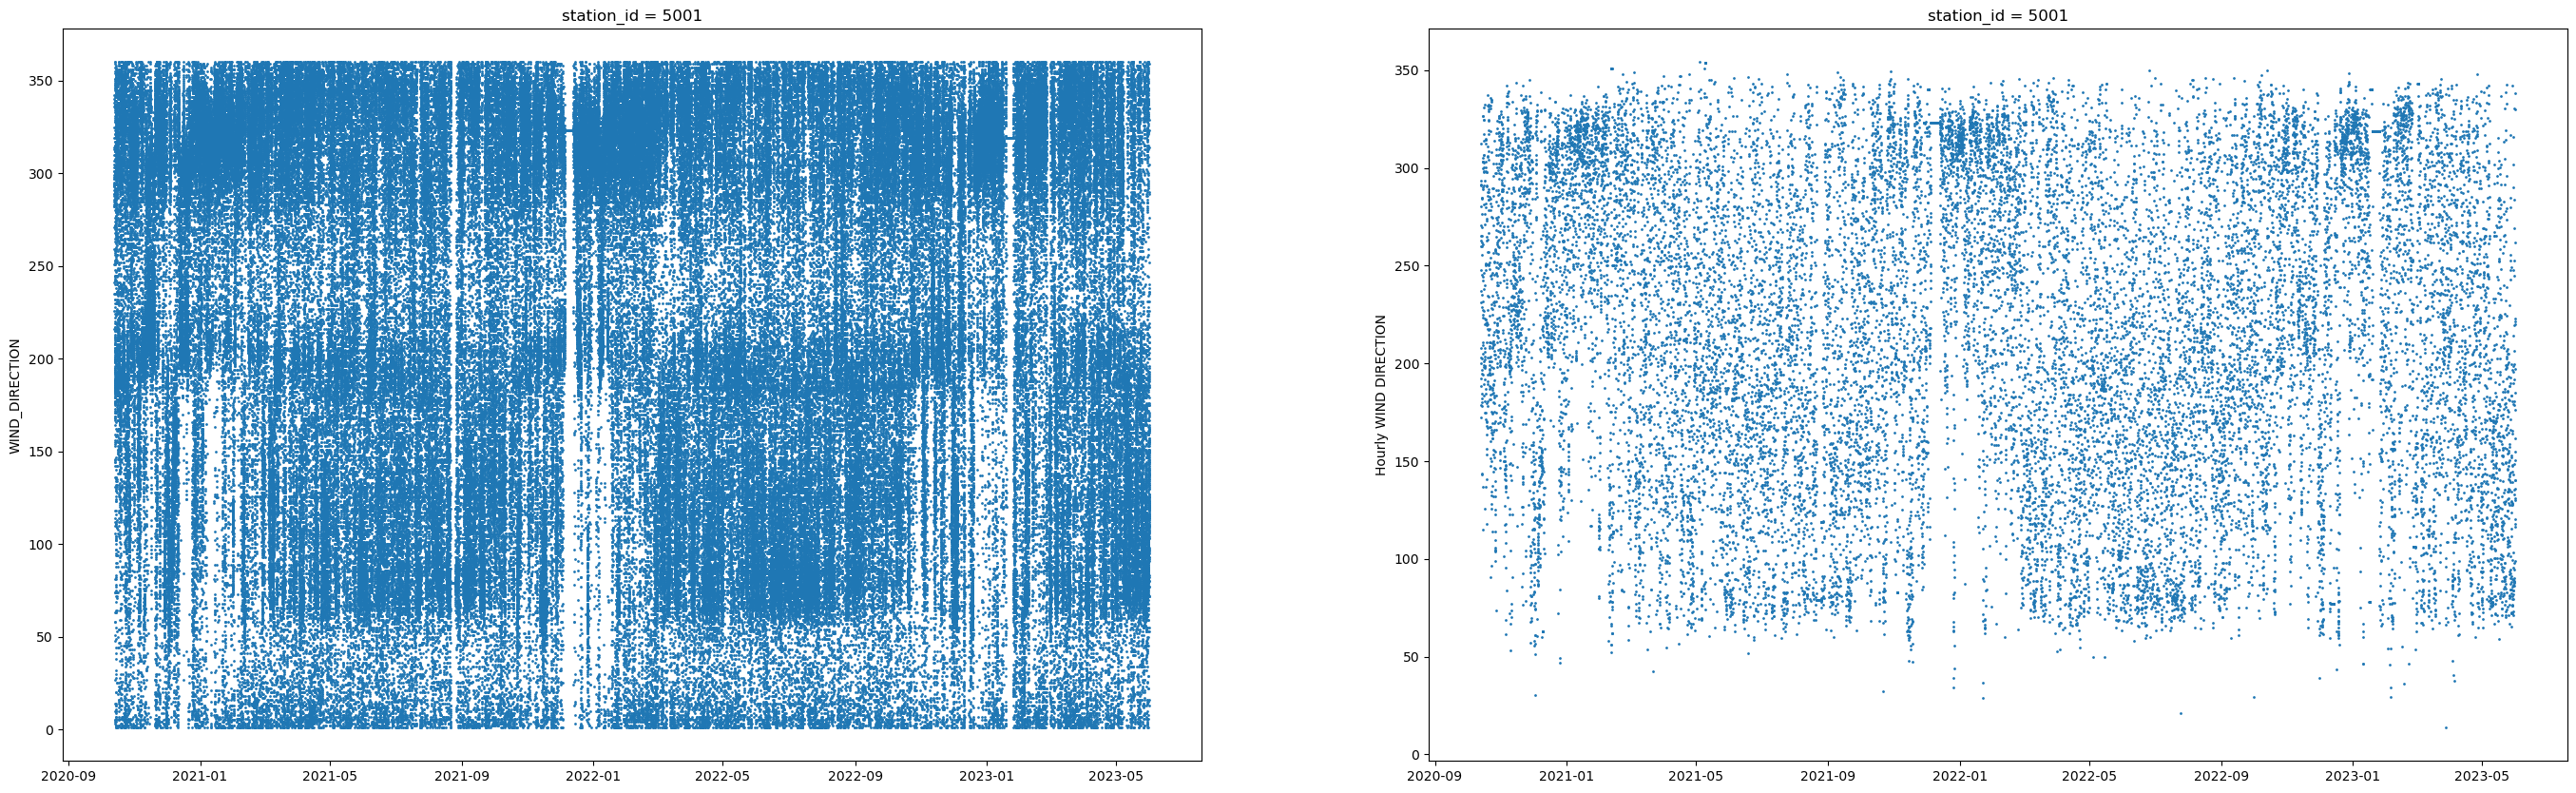

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(34, 10))

axs[0].scatter(direction_all.index, direction_all['WIND_DIRECTION'],s=1)
axs[0].set_ylabel('WIND_DIRECTION')  
axs[0].set_title(f'station_id = {station_id}') 

axs[1].scatter(direction_hourly.index, direction_hourly['WIND_DIRECTION'],s=1)
axs[1].set_ylabel('Hourly WIND DIRECTION')  
axs[1].set_title(f'station_id = {station_id}')  

plt.show()

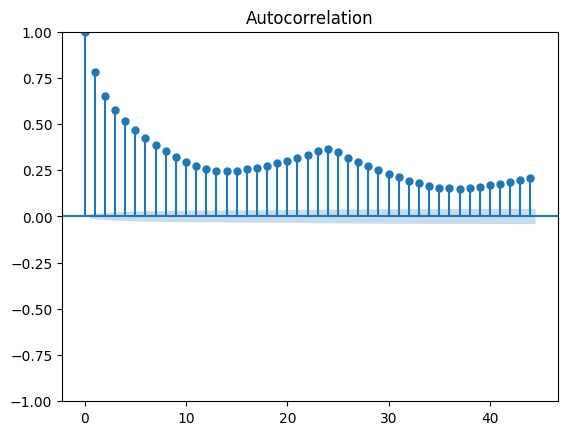

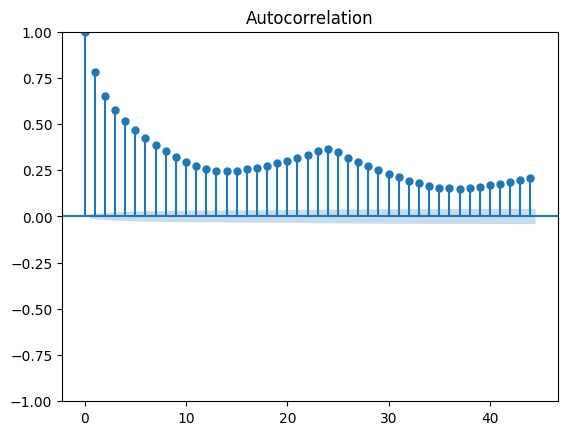

In [5]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(direction_hourly['WIND_DIRECTION'])

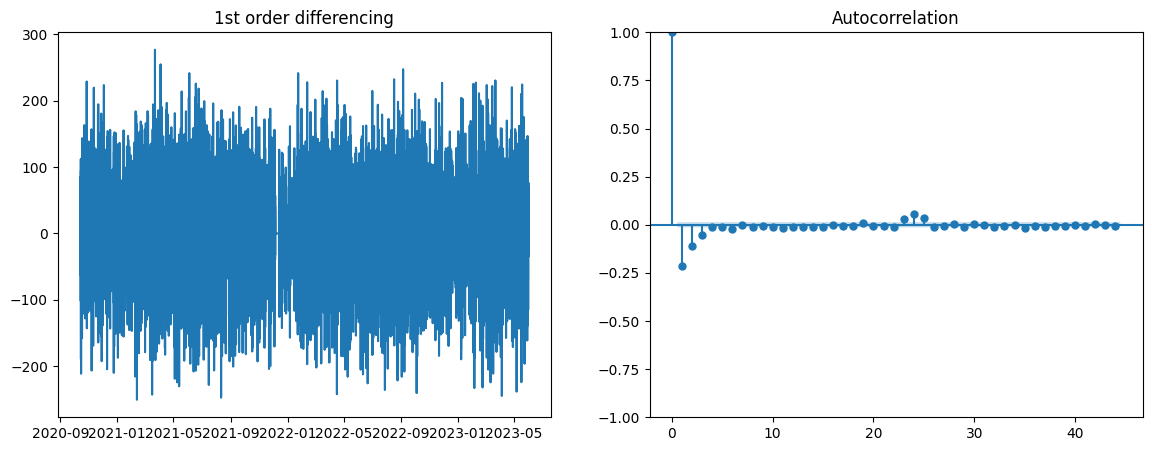

In [6]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().dropna(), ax=ax2)
plt.show()


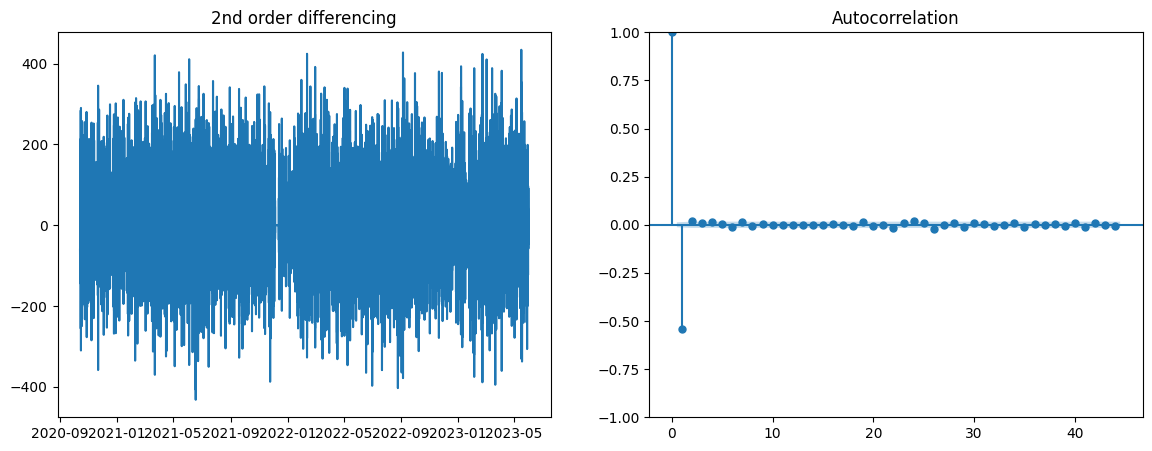

In [7]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().diff().dropna(), ax=ax2)
plt.show()

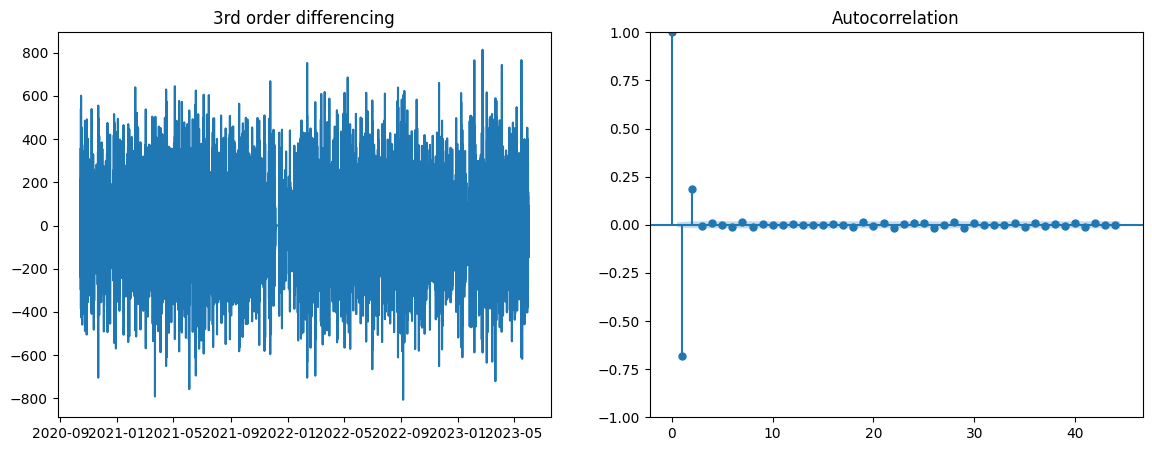

In [8]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(direction_hourly['WIND_DIRECTION'].dropna())
print('original data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 8.102396183394013e-22
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [11]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient direction data
from pmdarima import auto_arima
stepwise_fit = auto_arima(direction_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=21.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=248391.448, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=247328.361, Time=1.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=246810.423, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=248389.448, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=245103.172, Time=8.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=244996.054, Time=10.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=246726.727, Time=1.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=244923.814, Time=23.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=246391.134, Time=1.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=22.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=244969.354, Time=26.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=246245.953, Time=1.66 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=244926.558, Time=19.19 sec
 ARIMA(3,1,1)

                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                23052
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -122448.473
Date:                Wed, 22 May 2024   AIC                         244908.945
Time:                        01:27:00   BIC                         244957.218
Sample:                    10-13-2020   HQIC                        244924.631
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0470      0.082     12.789      0.000       0.887       1.207
ar.L2         -0.2239      0.052     -4.281      0.000      -0.326      -0.121
ar.L3          0.0302      0.010      3.150      0.0

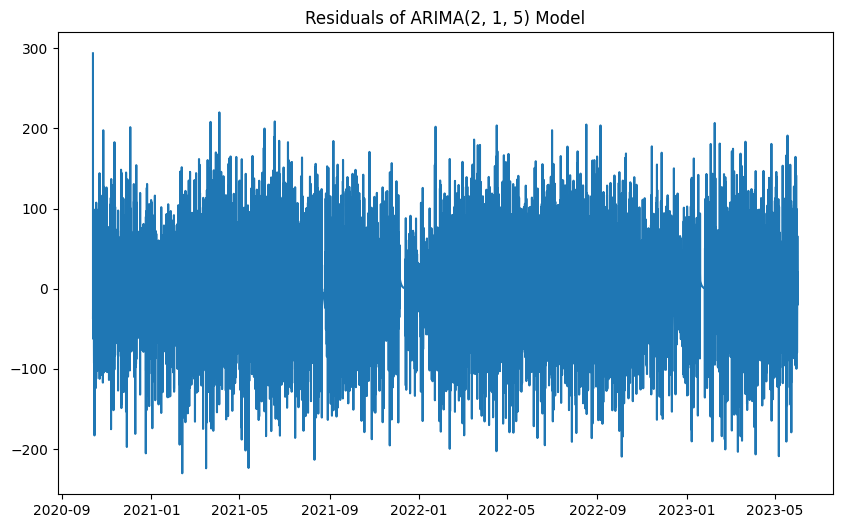

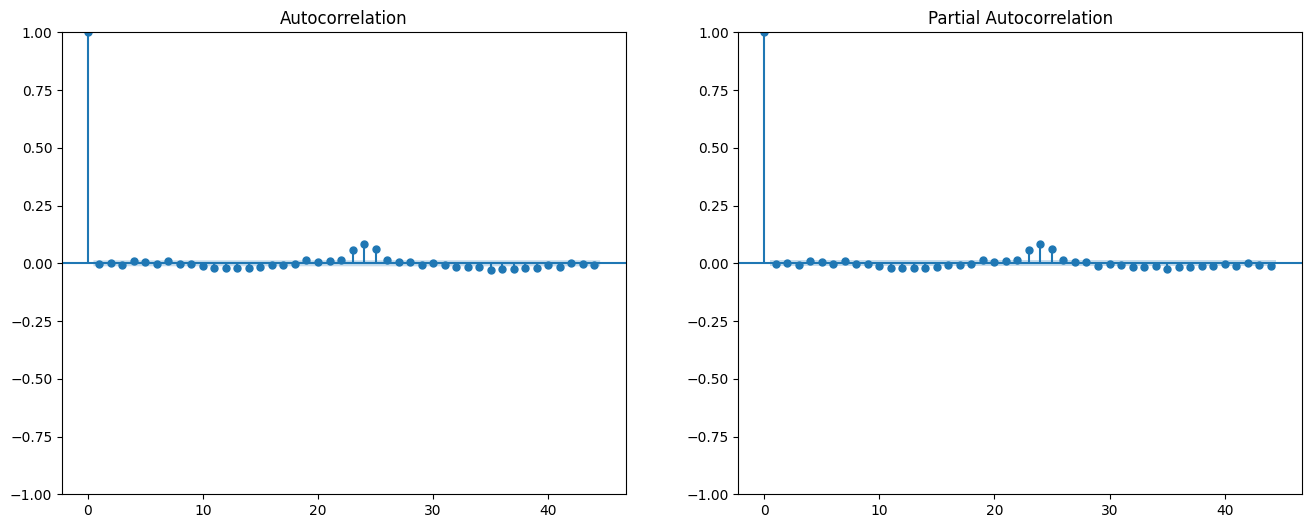

In [10]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(direction_hourly, order=(3,1,2))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,5} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order            AIC            BIC
90  (5, 0, 1)  244867.138713  244931.502776
39  (2, 0, 3)  244874.017833  244930.336388
59  (3, 0, 5)  244876.437002  244956.892081
58  (3, 0, 4)  244877.413886  244949.823456
77  (4, 0, 5)  244881.467572  244969.968158
Best ARIMA order: (5, 0, 1)
                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                23052
Model:                 ARIMA(5, 0, 1)   Log Likelihood             -122425.569
Date:                Mon, 20 May 2024   AIC                         244867.139
Time:                        02:10:24   BIC                         244931.503
Sample:                    10-13-2020   HQIC                        244888.053
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

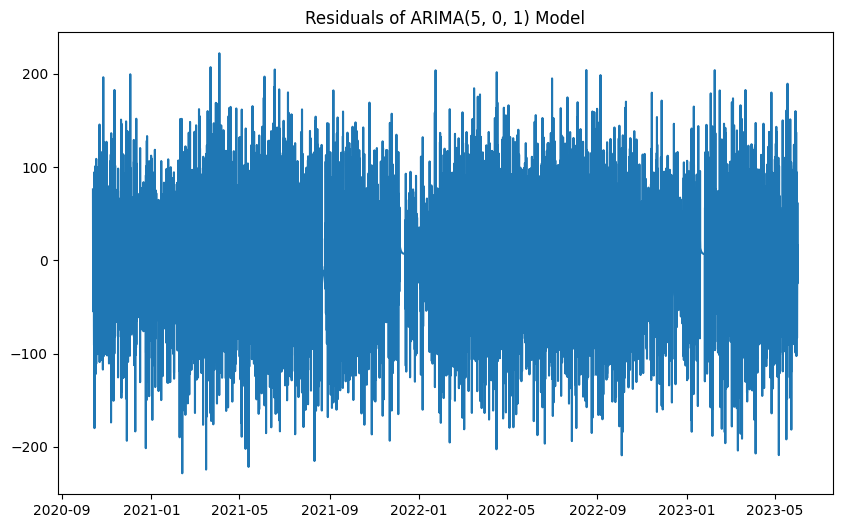

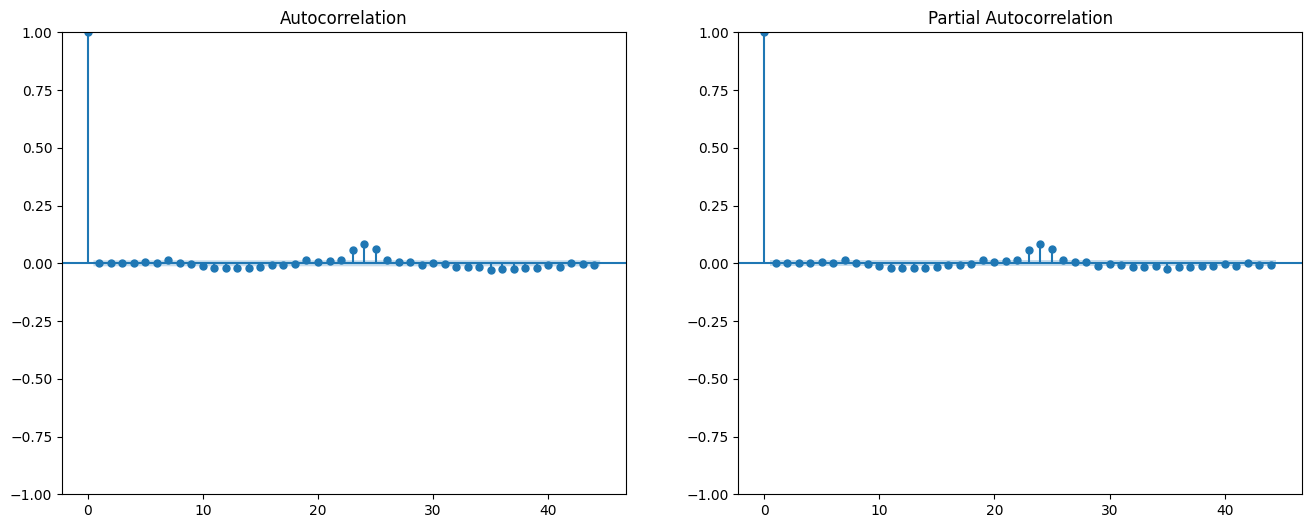

In [13]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(direction_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(direction_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [11]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (3,1,2) and (5,0,1) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

direction_20_21_22 = direction_hourly.loc[(direction_hourly.index.year == 2020) | (direction_hourly.index.year == 2021) | (direction_hourly.index.year == 2022) , 'WIND_DIRECTION']
print(direction_20_21_22)

2020-10-13 10:00:00+00:00    293.625000
2020-10-13 11:00:00+00:00    312.666667
2020-10-13 12:00:00+00:00    270.833333
2020-10-13 13:00:00+00:00    291.083333
2020-10-13 14:00:00+00:00    280.416667
                                ...    
2022-12-31 19:00:00+00:00    327.166667
2022-12-31 20:00:00+00:00    300.833333
2022-12-31 21:00:00+00:00    329.583333
2022-12-31 22:00:00+00:00    326.916667
2022-12-31 23:00:00+00:00    323.000000
Freq: H, Name: WIND_DIRECTION, Length: 19430, dtype: float64


Now we will create a simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [12]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(direction_20_21_22, 24)

last_3_direction = last_3_days_average(direction_20_21_22, 24)


In [13]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(direction_20_21_22, 24)

today_is_tomorrow_direction = today_is_tomorrow(direction_20_21_22, 24)


In [14]:
# ARIMA(3,1,2) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_312 = ARIMA(direction_20_21_22, order=(3,1,2))
fit_312 = model_312.fit()

# summary of the fit
print(fit_312.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_312 = fit_312.get_forecast(steps=24)
forecast_values_312 = forecast_result_312.predicted_mean
conf_int_312 = forecast_result_312.conf_int()

print("Forecasted values:", forecast_values_312)
print("95% Confidence intervals of forecasts:", conf_int_312)


                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                19430
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -103186.523
Date:                Wed, 22 May 2024   AIC                         206385.046
Time:                        01:27:13   BIC                         206432.293
Sample:                    10-13-2020   HQIC                        206400.526
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5841      0.153      3.830      0.000       0.285       0.883
ar.L2          0.0733      0.098      0.745      0.456      -0.120       0.266
ar.L3          0.0480      0.011      4.327      0.0

In [15]:
print(forecast_values_312)

2023-01-01 00:00:00+00:00    316.245252
2023-01-01 01:00:00+00:00    311.555706
2023-01-01 02:00:00+00:00    308.133007
2023-01-01 03:00:00+00:00    305.465403
2023-01-01 04:00:00+00:00    303.430959
2023-01-01 05:00:00+00:00    301.882580
2023-01-01 06:00:00+00:00    300.700821
2023-01-01 07:00:00+00:00    299.799268
2023-01-01 08:00:00+00:00    299.111620
2023-01-01 09:00:00+00:00    298.587077
2023-01-01 10:00:00+00:00    298.186950
2023-01-01 11:00:00+00:00    297.881734
2023-01-01 12:00:00+00:00    297.648913
2023-01-01 13:00:00+00:00    297.471318
2023-01-01 14:00:00+00:00    297.335847
2023-01-01 15:00:00+00:00    297.232510
2023-01-01 16:00:00+00:00    297.153684
2023-01-01 17:00:00+00:00    297.093555
2023-01-01 18:00:00+00:00    297.047688
2023-01-01 19:00:00+00:00    297.012701
2023-01-01 20:00:00+00:00    296.986013
2023-01-01 21:00:00+00:00    296.965655
2023-01-01 22:00:00+00:00    296.950126
2023-01-01 23:00:00+00:00    296.938281
Freq: H, Name: predicted_mean, dtype: fl

In [16]:
# ARIMA(5,0,1) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_501 = ARIMA(direction_20_21_22, order=(5,0,1))
fit_501 = model_501.fit()

# summary of the fit
print(fit_501.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_501 = fit_501.get_forecast(steps=24)
forecast_values_501 = forecast_result_501.predicted_mean
conf_int_501 = forecast_result_501.conf_int()

print("Forecasted values:", forecast_values_501)
print("95% Confidence intervals of forecasts:", conf_int_501)





                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                19430
Model:                 ARIMA(5, 0, 1)   Log Likelihood             -103151.999
Date:                Wed, 22 May 2024   AIC                         206319.998
Time:                        01:27:34   BIC                         206382.995
Sample:                    10-13-2020   HQIC                        206340.638
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        217.6837      5.524     39.407      0.000     206.857     228.510
ar.L1          1.6363      0.008    215.087      0.000       1.621       1.651
ar.L2         -0.6031      0.012    -52.154      0.0

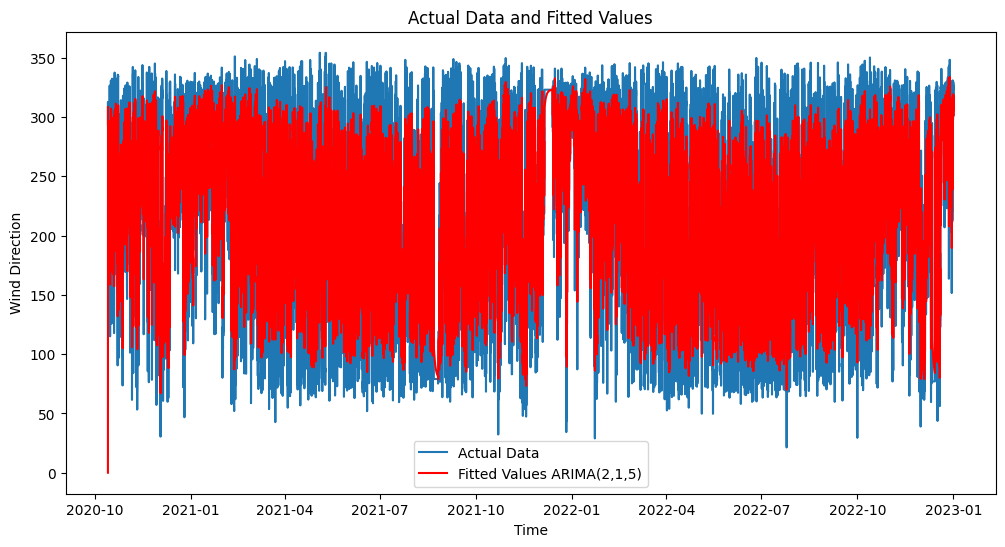

In [17]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_312 = fit_312.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(direction_20_21_22.index, direction_20_21_22, label='Actual Data')
plt.plot(direction_20_21_22.index, fitted_values_312, color='red', label='Fitted Values ARIMA(2,1,5)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind Direction')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

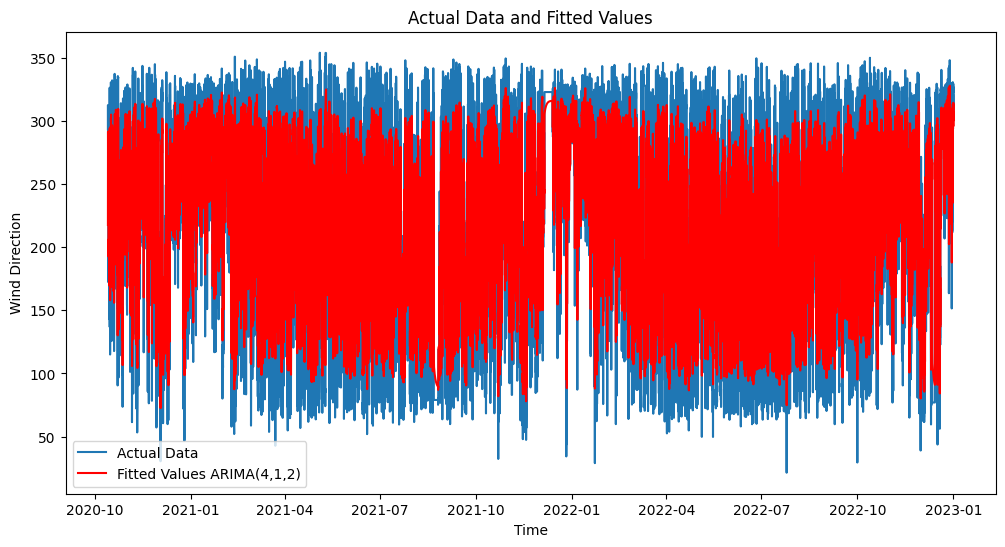

In [18]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_501 = fit_501.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(direction_20_21_22.index, direction_20_21_22, label='Actual Data')
plt.plot(direction_20_21_22.index, fitted_values_501, color='red', label='Fitted Values ARIMA(4,1,2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind Direction')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

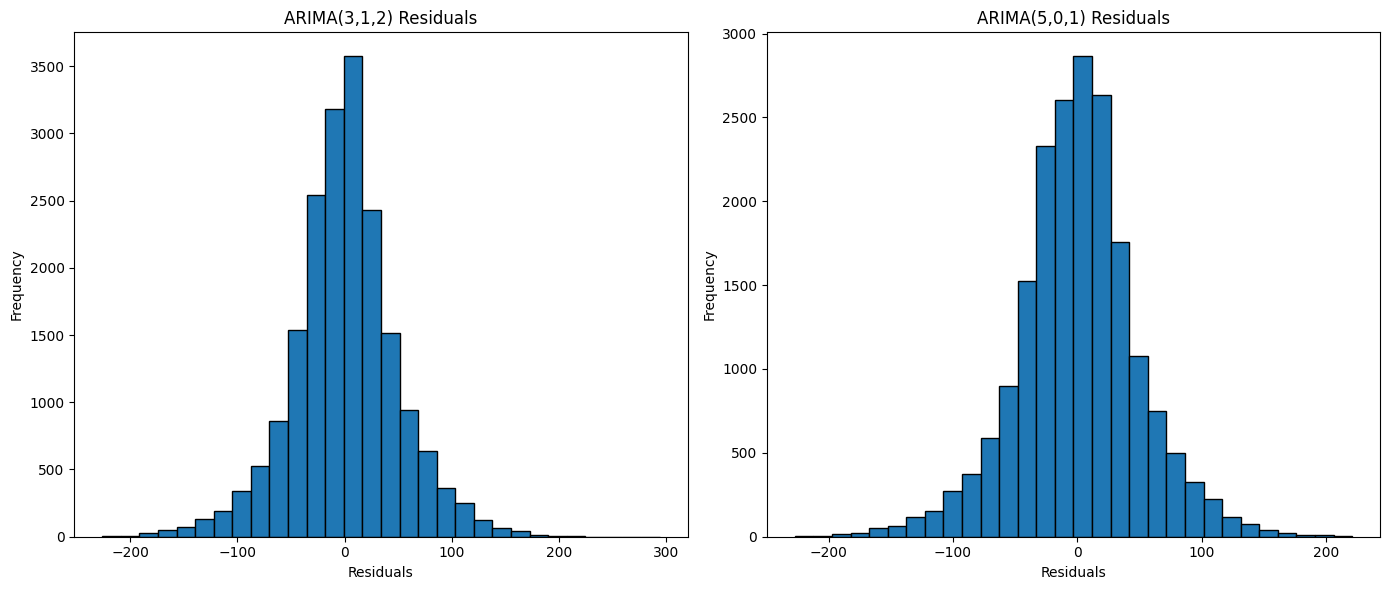

In [19]:
# comparison of the histograms

# residuals
residuals_312 = fit_312.resid
residuals_501 = fit_501.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_312, bins=30, edgecolor='k')
plt.title('ARIMA(3,1,2) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_501, bins=30, edgecolor='k')
plt.title('ARIMA(5,0,1) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [20]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_312)
mean2 = np.mean(residuals_501)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_312.aic
aic2 = fit_501.aic
#print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(3,1,2) is better based on AIC.')
else:
    print('ARIMA(5,0,1) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

ARIMA(5,0,1) is preferred based on AIC.


Mean Absolute Error: 36.618929645929406
Mean Squared Error: 2392.1324732814414


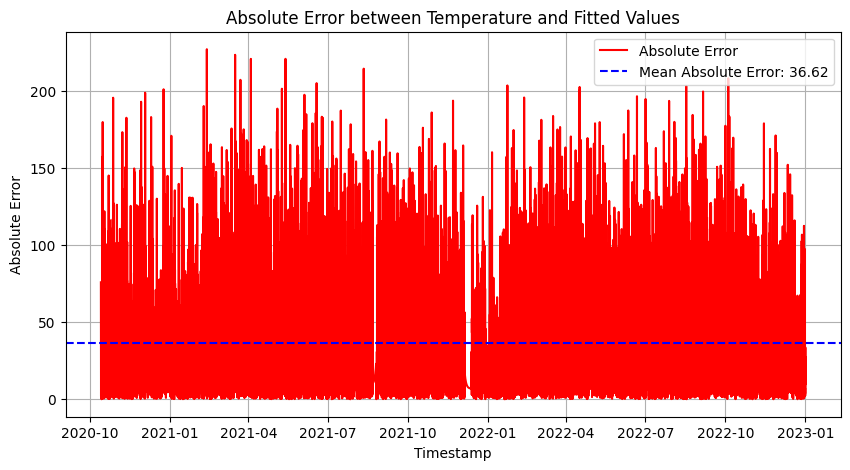

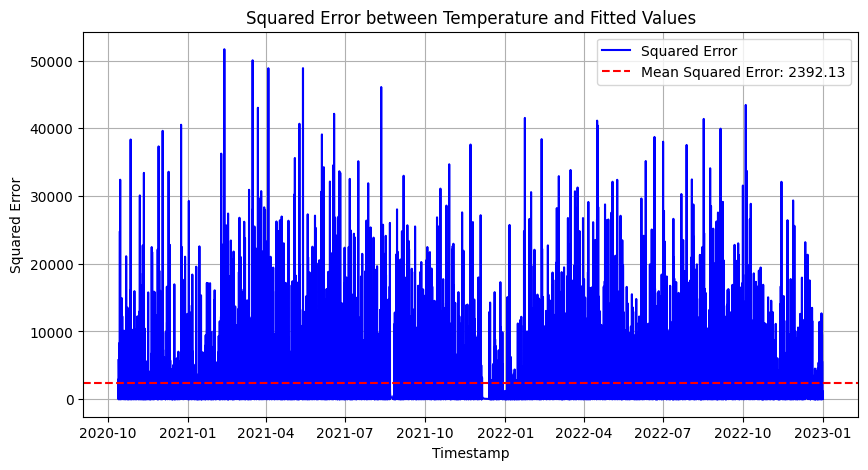

In [23]:
# absolute error comparison - actual data vs fitted model data

def calculate_errors(data, model): 
      # model are fitted values of a chosen model
  if isinstance(data, pd.Series) and isinstance(model, pd.Series):
        absolute_error = (data - model).abs()
        squared_error = (data - model) ** 2
  elif isinstance(data, np.ndarray) and isinstance(model, np.ndarray):
        absolute_error = np.abs(data - model)
        squared_error = (data - model) ** 2
  errors = pd.DataFrame({
        'absolute_error': absolute_error,
        'squared_error': squared_error
  })

  return errors

# (4,1,2) is the preferred, lets compare this data with actual data
# actual data - temperature_20_21_22
# fitted values data - fitted_values_412 

errors = calculate_errors(direction_20_21_22, fitted_values_501)

# mean errors
mean_absolute_error = errors['absolute_error'].mean()
mean_squared_error = errors['squared_error'].mean()
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mean_squared_error)

# plot of the absolute error
plt.figure(figsize=(10, 5))
plt.plot(errors['absolute_error'], label='Absolute Error', color='red')
plt.axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Temperature and Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

# plot of the squared error
plt.figure(figsize=(10, 5))
plt.plot(errors['squared_error'], label='Squared Error', color='blue')
plt.axhline(y=mean_squared_error, color='red', linestyle='--', label=f'Mean Squared Error: {mean_squared_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Squared Error')
plt.title('Squared Error between Temperature and Fitted Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    

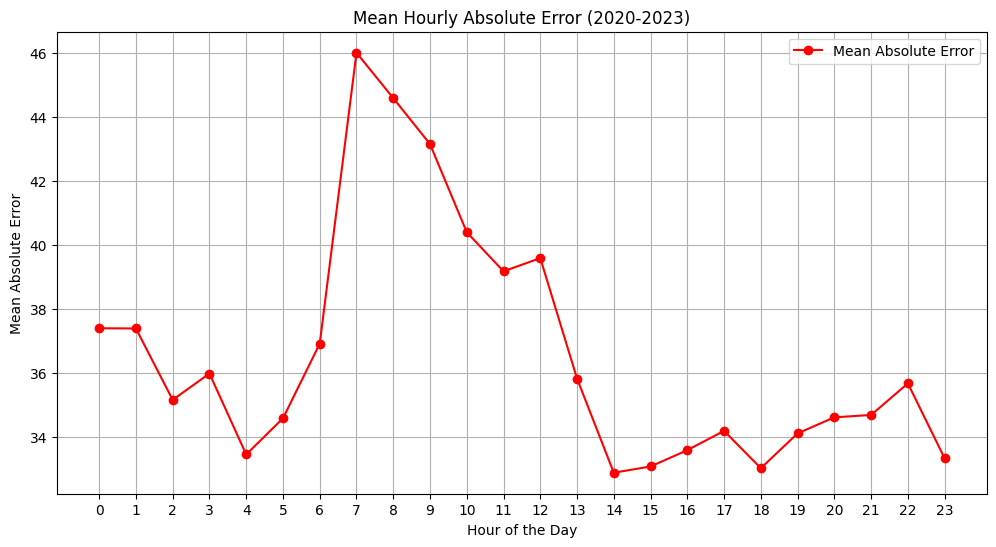

Hour
0     37.399969
1     37.392583
2     35.162724
3     35.986980
4     33.459678
5     34.587734
6     36.916281
7     46.000389
8     44.584297
9     43.147707
10    40.398060
11    39.177097
12    39.588954
13    35.828801
14    32.889896
15    33.085212
16    33.594155
17    34.196234
18    33.031394
19    34.118188
20    34.619048
21    34.692901
22    35.678363
23    33.340443
Name: absolute_error, dtype: float64


In [24]:
# mean hourly absolute errors

errors['Hour'] = errors.index.hour

# mean
mean_absolute_errors_by_hour = errors.groupby('Hour')['absolute_error'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(mean_absolute_errors_by_hour.index, mean_absolute_errors_by_hour, label='Mean Absolute Error', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Hourly Absolute Error (2020-2023)')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(24))
plt.show()

print(mean_absolute_errors_by_hour)

In [21]:
# actual measurements for 1 day (24 steps) into the future
w_direction_hourly = direction_hourly['WIND_DIRECTION']
actual_values_direction_23 = w_direction_hourly['2023'].head(24)
print(actual_values_direction_23)

2023-01-01 00:00:00+00:00    327.083333
2023-01-01 01:00:00+00:00    326.083333
2023-01-01 02:00:00+00:00    310.916667
2023-01-01 03:00:00+00:00    319.750000
2023-01-01 04:00:00+00:00    325.083333
2023-01-01 05:00:00+00:00    322.000000
2023-01-01 06:00:00+00:00    323.500000
2023-01-01 07:00:00+00:00    318.166667
2023-01-01 08:00:00+00:00    264.083333
2023-01-01 09:00:00+00:00    144.666667
2023-01-01 10:00:00+00:00    298.583333
2023-01-01 11:00:00+00:00    207.333333
2023-01-01 12:00:00+00:00    176.833333
2023-01-01 13:00:00+00:00    275.250000
2023-01-01 14:00:00+00:00    310.166667
2023-01-01 15:00:00+00:00    327.500000
2023-01-01 16:00:00+00:00    298.416667
2023-01-01 17:00:00+00:00    307.583333
2023-01-01 18:00:00+00:00    317.750000
2023-01-01 19:00:00+00:00    325.250000
2023-01-01 20:00:00+00:00    327.250000
2023-01-01 21:00:00+00:00    327.416667
2023-01-01 22:00:00+00:00    326.000000
2023-01-01 23:00:00+00:00    321.500000
Freq: H, Name: WIND_DIRECTION, dtype: fl

                               Actual  ARIMA(3,1,2)  ARIMA(5,0,1)  \
2023-01-01 00:00:00+00:00  327.083333    316.245252    310.874243   
2023-01-01 01:00:00+00:00  326.083333    311.555706    303.496614   
2023-01-01 02:00:00+00:00  310.916667    308.133007    298.026015   
2023-01-01 03:00:00+00:00  319.750000    305.465403    293.643562   
2023-01-01 04:00:00+00:00  325.083333    303.430959    289.975082   
2023-01-01 05:00:00+00:00  322.000000    301.882580    286.991075   
2023-01-01 06:00:00+00:00  323.500000    300.700821    284.558523   
2023-01-01 07:00:00+00:00  318.166667    299.799268    282.557230   
2023-01-01 08:00:00+00:00  264.083333    299.111620    280.894574   
2023-01-01 09:00:00+00:00  144.666667    298.587077    279.501559   
2023-01-01 10:00:00+00:00  298.583333    298.186950    278.323102   
2023-01-01 11:00:00+00:00  207.333333    297.881734    277.315153   
2023-01-01 12:00:00+00:00  176.833333    297.648913    276.442747   
2023-01-01 13:00:00+00:00  275.250

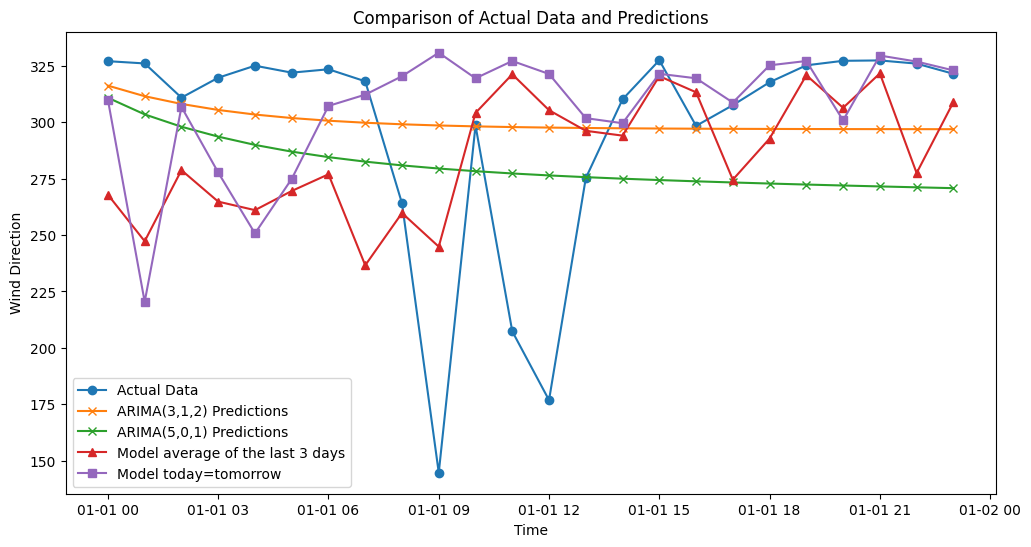

In [22]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_direction = pd.DataFrame({
    'Actual': actual_values_direction_23,
    'ARIMA(3,1,2)': forecast_values_312,
    'ARIMA(5,0,1)': forecast_values_501,
    'Model average of the last 3 days': last_3_direction,
    'Model today=tomorrow': today_is_tomorrow_direction
})

print(comparison_direction)

plt.figure(figsize=(12,6))

plt.plot(comparison_direction.index, comparison_direction['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_direction.index, comparison_direction['ARIMA(3,1,2)'], label='ARIMA(3,1,2) Predictions', marker='x')
plt.plot(comparison_direction.index, comparison_direction['ARIMA(5,0,1)'], label='ARIMA(5,0,1) Predictions', marker='x')
plt.plot(comparison_direction.index, comparison_direction['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_direction.index, comparison_direction['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Wind Direction')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()

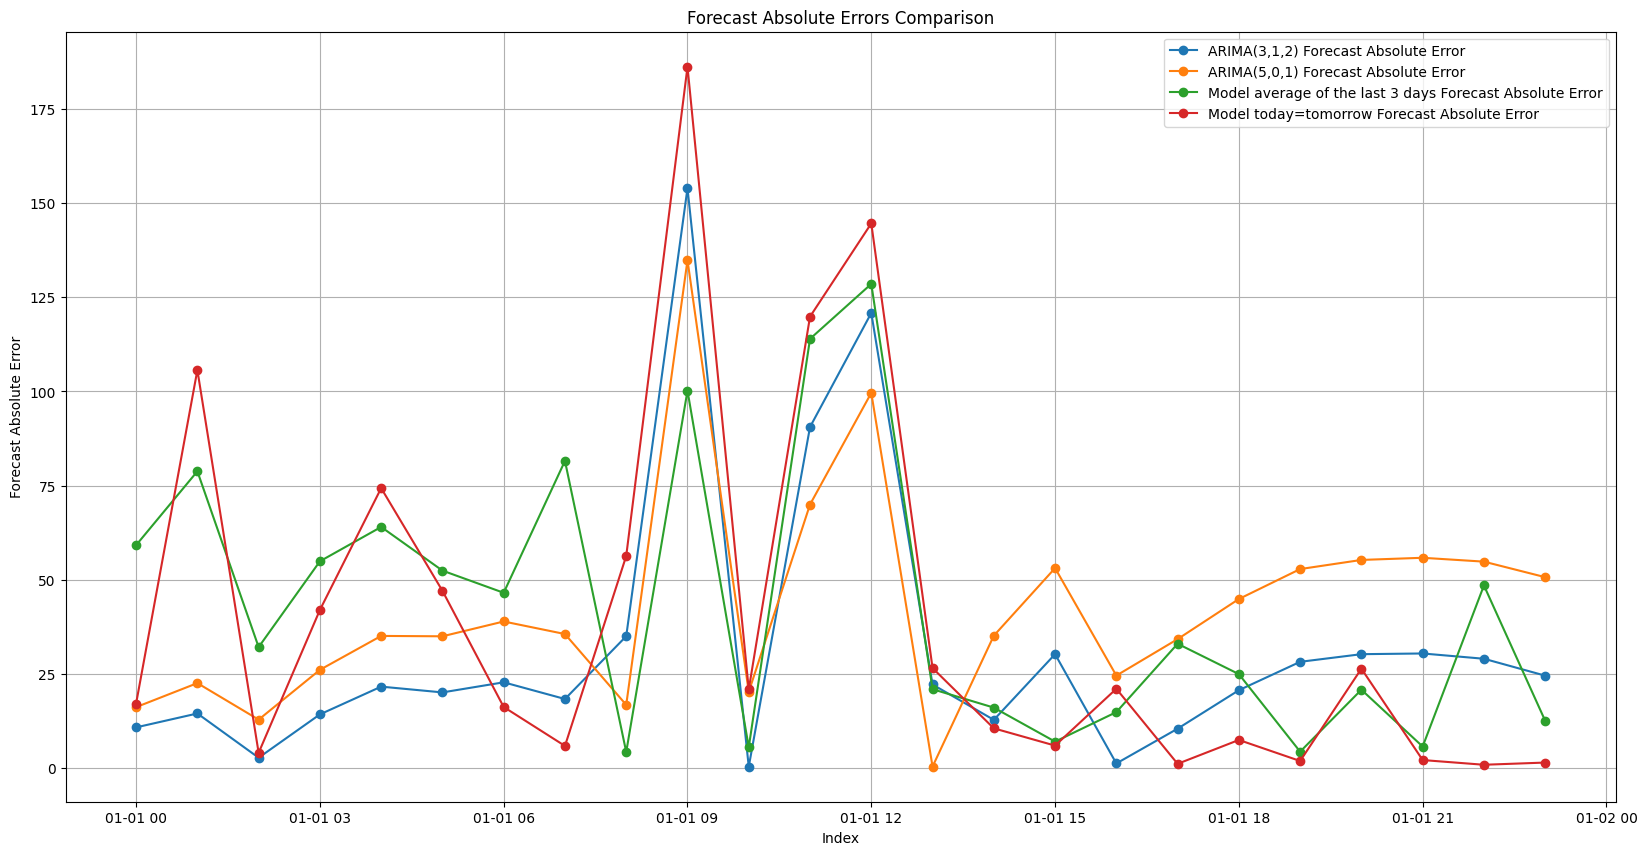

ARIMA(3,1,2) Forecast Absolute Error                        31.934083
ARIMA(5,0,1) Forecast Absolute Error                        42.745978
Model average of the last 3 days Forecast Absolute Error    42.967593
Model today=tomorrow Forecast Absolute Error                39.423611
dtype: float64


In [25]:
# 4 models' predictions compared to the actual data

# absolute errors of all the modela
forecast_absolute_errors = pd.DataFrame()
for column in comparison_direction.columns:
    if column != 'Actual':
        forecast_absolute_errors[column + ' Forecast Absolute Error'] = (comparison_direction['Actual'] - comparison_direction[column]).abs()

# plot
plt.figure(figsize=(20, 10))
for column in forecast_absolute_errors.columns:
    plt.plot(forecast_absolute_errors[column], label=column, marker='o')

plt.xlabel('Index')
plt.ylabel('Forecast Absolute Error')
plt.title('Forecast Absolute Errors Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# values 
#print(forecast_absolute_errors)

# mean errors
print(forecast_absolute_errors.mean())
